In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

In [ ]:
import pickle
from nltk.corpus import movie_reviews
from nltk import FreqDist
from nltk.corpus import stopwords
import operator
from nltk.tokenize import word_tokenize

# Functions

Get the most influential words in a given category

In [1]:
def mostInfluential(clf, wordFeatures, category):
    Influence = {}
    prior = clf.prob_classify(featureFinder('', wordFeature)).prob(category)
    for word in wordFeatures:
        ratio = float(clf.prob_classify(featureFinder(word, wordFeature)).prob(category))/prior
        if ratio >= 1:
            Influence[word] = ratio
    
    sortedInfluence = sorted(Influence.items(), key=operator.itemgetter(1), reverse=True)
    return sortedInfluence

Correct for bias towards negative prediction

In [2]:
def classify(cls, text, features):
    prior = cls.prob_classify(featureFinder('', features)).prob('neg')
    ratio = float(cls.prob_classify(featureFinder(text, features)).prob('neg'))/prior
    if ratio > 1:
        return ('Neg', ratio)
    elif ratio < 1:
        return ('Pos', ratio)
    elif ratio == 1:
        return ("Neutral", ratio)

Find the features from a given text and label True / False for the existence of the feature in the text

In [3]:
def featureFinder(doc, wordFeature):
    
    if type(doc) == str:
        words = set(doc.split())
        features = {}
        for word in wordFeature:
            features[word] = (word in words)

        return features
    
    else:
        words = set(doc)
        features = {}
        for word in wordFeature:
            features[word] = (word in words)

        return features    

Computes the Pos to Neg ratio in the training and test set

In [4]:
def posNegRatioTrainTest(train, test):
    trainPos = 0
    trainNeg = 0
    for i in range(len(train)):
        if train[i][1] == 'pos':
            trainPos += 1
        elif train[i][1] == 'neg':
            trainNeg += 1
            
    trainRatio = float(trainPos)/(float(trainPos) + trainNeg)

    print 'Pos to Neg ratio in train set is: {} pos : {} neg - ({:.2f}% pos)'.format(trainPos, trainNeg, trainRatio)
    
    testPos = 0
    testNeg = 0
    for i in range(len(test)):
        if test[i][1] == 'pos':
            testPos += 1
        elif test[i][1] == 'neg':
            testNeg += 1
            
    testRatio = float(testPos)/(float(testPos) + testNeg)

    print 'Pos to Neg ratio in test set is: {} pos : {} neg - ({:.2f}% pos)'.format(testPos, testNeg, testRatio)

# nltk training data

First train data: the NLTK movie review data

In [13]:
data = [(list(movie_reviews.words(fileid)), str(category))
        for category in movie_reviews.categories()
        for fileid in movie_reviews.fileids(category)]

##### Clean the raw data

In [14]:
allWordsLower = [str(word.lower()) for word in movie_reviews.words()]

stopWordsList = stopwords.words('english')

allWordsLowerClean = []
for word in allWordsLower:
    try:
        if ((word not in stopWordsList) & (len(word) >= 2)):
            allWordsLowerClean.append(str(word))
    except:
        continue

##### Extract features

In [15]:
allWordsDist = FreqDist(allWordsLowerClean)

wordFeatureNltk = [word for (word, n) in allWordsDist.most_common()[7:4000]]

##### Train test split

In [37]:
for i in range(len(data)):
    for j in range(len(data[i][0])):
        data[i][0][j] = str(data[i][0][j])

In [38]:
featureSetNltk = [(featureFinder(rev, wordFeatureNltk), cat) for (rev, cat) in data]

random.shuffle(featureSetNltk)

trainRatio = 0.8
train = featureSet[:int(len(featureSetNltk)*trainRatio)]
test = featureSet[int(len(featureSetNltk)*trainRatio):]

In [39]:
posNegRatioTrainTest(train, test)

Pos to Neg ratio in train set is: 793 pos : 807 neg - (0.50% pos)
Pos to Neg ratio in test set is: 4170 pos : 4211 neg - (0.50% pos)


# Tweeter training data

Second training data: labeled tweeter feeds

In [16]:
tweeterData = pd.read_csv('training.1600000.processed.noemoticon.csv', header=None)

In [17]:
tweeterData = tweeterData[[0,5]]

tweeterData.columns = ['lab', 'tweet']

labNew = []
for val in tweeterData.lab:
    if val == 0:
        labNew.append('neg')
    elif val == 4:
        labNew.append('pos')

tweeterData.lab = labNew

In [18]:
tweeterDataList = []
size = 10000
tweeterDatasample = tweeterData.sample(size)
tweeterDatasample.index = range(len(tweeterDatasample))
for i in range(tweeterDatasample.shape[0]):
    try:
        tweeterDataList.append([word_tokenize(tweeterDatasample.tweet[i]), tweeterDatasample.lab[i]])
    except:
        continue

##### Clean raw data

In [22]:
def cleanUpWords(listOfWords):
    
    stopWordsList = stopwords.words('english')
    stopChar = ['.', ',', ':',';', "'", '/']

    allWordsLowerClean = []
    for word in allWordsLower:
        try:
            if ((word not in stopWordsList) & (word not in stopChar) & (word.isalpha()) & (len(word) >= 2)):
                allWordsLowerClean.append(str(word))
        except:
            continue
    
    p = float(len(allWordsLowerClean))/len(listOfWords)
    
    print 'Length of clean words list: {} ({:.2f}% of original)'.format(len(allWordsLowerClean), p*100)
    print 
    return allWordsLowerClean

In [23]:
allWordsLower = []
for i in range(len(tweeterDataList)):
    for word in tweeterDataList[i][0]:
        allWordsLower.append(word.lower())

In [24]:
allWordsLowerClean = cleanUpWords(allWordsLower)

C:\Users\dell\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Length of clean words list: 71517 (43.92% of original)



##### Extract features

In [25]:
allWordsDist = FreqDist(allWordsLowerClean)

wordFeature = [word for (word, n) in allWordsDist.most_common()[:4000]]

In [18]:
allWordsDist.most_common(4000)[:15]

[('good', 569),
 ('get', 538),
 ('like', 478),
 ('go', 472),
 ('day', 469),
 ('got', 434),
 ('http', 426),
 ('today', 408),
 ('work', 399),
 ('quot', 389),
 ('going', 385),
 ('love', 381),
 ('back', 379),
 ('lol', 376),
 ('time', 363)]

##### Train test split

In [28]:
featureSet = [(featureFinder(rev, wordFeature), cat) for (rev, cat) in tweeterDataList]

random.shuffle(featureSet)

trainRatio = 0.8
train = featureSet[:int(len(featureSet)*trainRatio)]
test = featureSet[int(len(featureSet)*trainRatio):]

In [20]:
posNegRatioTrainTest(train, test)

Pos to Neg ratio in train set is: 4021 pos : 3965 neg - (0.50% pos)
Pos to Neg ratio in test set is: 975 pos : 1022 neg - (0.49% pos)


# Train classifiers

In [31]:
from nltk import NaiveBayesClassifier as nb
from nltk.classify import accuracy
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier

In [149]:
lmMod = SklearnClassifier(LogisticRegression(penalty='l2', C=1.0, fit_intercept=True))
lmMod.train(train)
print 'LR: Training accuracy: {trainA:.2f}, Testing accuracy {testA:.2f}'.format(trainA=accuracy(lmMod, train),
                                                                         testA=accuracy(lmMod, test))

LR: Training accuracy: 1.00, Testing accuracy 0.84


In [174]:
nbBernoulliMod = SklearnClassifier(BernoulliNB(alpha=1.0, fit_prior=True))
nbBernoulliMod.train(train)
print 'LR: Training accuracy: {trainA:.2f}, Testing accuracy {testA:.2f}'.format(trainA=accuracy(nbBernoulliMod, train),
                                                                                 testA=accuracy(nbBernoulliMod, test))

LR: Training accuracy: 0.89, Testing accuracy 0.79


In [175]:
adaMod = SklearnClassifier(AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0))
adaMod.train(train)
print 'LR: Training accuracy: {trainA:.2f}, Testing accuracy {testA:.2f}'.format(trainA=accuracy(adaMod, train),
                                                                                 testA=accuracy(adaMod, test))

LR: Training accuracy: 0.87, Testing accuracy 0.75


In [176]:
treeMod = SklearnClassifier(ExtraTreesClassifier())
treeMod.train(train)
print 'LR: Training accuracy: {trainA:.2f}, Testing accuracy {testA:.2f}'.format(trainA=accuracy(treeMod, train),
                                                                                 testA=accuracy(treeMod, test))

LR: Training accuracy: 1.00, Testing accuracy 0.69


### Hyper-parameter optimization 

Perform a randomized grid search for hyper parameter tuning on the best out-of-the-box algorithms

In [30]:
from scipy.stats import randint
import operator

In [21]:
def randomizedGridSearch(cls, train, test, param_distributions, n_iter=10, verbose=False):
    result = {}
    
    for i in range(n_iter):
        
        #Get params
        params = {}
        for key in param_distributions.iterkeys():
            params[key] = [np.random.choice(val) for (k, val) in param_distributions.iteritems() if k == key][0]
        
        #Params update
        clsWithParams = SklearnClassifier(cls.set_params(**params))
        
        #train
        clsWithParamsTrained = clsWithParams.train(train)
        
        #Train and test accuracy
        trainAccuracy = accuracy(clsWithParamsTrained, train)
        testAccuracy = accuracy(clsWithParamsTrained, test)
        
        paramsList = [(ke, val) for (ke, val) in params.iteritems()]

        result[len(result)+1] = [testAccuracy, trainAccuracy, paramsList]
        
        if verbose == True:
            print 'Best so far: {}'.format(sorted(result.items(), key=operator.itemgetter(1), reverse=True)[0])
    
    resultSorted = sorted(result.items(), key=operator.itemgetter(1), reverse=True)
    bestTestAccuracy = resultSorted[0][1][0]
    bestTrainAccuracy = resultSorted[0][1][1]
    
    print 'Best Test Accuracy: {:.3f}%'.format(bestTestAccuracy)
    print 'Train Accuracy: {:.3f}%'.format(bestTrainAccuracy)
    print 'Parameters: {}'.format(resultSorted[0][1][2])
    
    return sorted(result.items(), key=operator.itemgetter(1), reverse=True)

##### Logistic regression

In [111]:
lmModSklearn = LogisticRegression(penalty='l2', C=1.0, fit_intercept=True)

In [110]:
HyperParams = {'penalty': ['l2', 'l1'], 'C': np.arange(0,10,0.1), 'fit_intercept': [True, False]}

In [201]:
bestLm = randomizedGridSearch(lmModSklearn, train=train, test=test, param_distributions=HyperParams, n_iter=10)

Best Test Accuracy: 0.835%
Best Train Accuracy: 1.000%
Parameters: [('penalty', 'l2'), ('C', 3.1000000000000001), ('fit_intercept', True)]


##### Adaboost

In [34]:
adaModSklearn = AdaBoostClassifier(n_estimators=50)

In [35]:
HyperParamsAda = {'n_estimators': np.arange(50,500,50)}

In [ ]:
bestAda = randomizedGridSearch(adaModSklearn, train=train, test=test, param_distributions=HyperParamsAda, verbose=True,
                               n_iter=10)

In [45]:
bestAda[0]

(8, [0.8175, 1.0, [('n_estimators', 400)]])

##### Naive bayes - Bernoulli

In [46]:
nbModSklearn = BernoulliNB(alpha=1.0, binarize=None, fit_prior=True)

In [49]:
HyperParamsNb = {'alpha': np.arange(0.1, 2.0, 0.1), 'fit_prior': [True, False]}

In [50]:
bestNb = randomizedGridSearch(nbModSklearn, train=train, test=test, param_distributions=HyperParamsNb, verbose=True,
                               n_iter=10)

Best so far: (1, [0.805, 0.888125, [('alpha', 0.59999999999999998), ('fit_prior', True)]])
Best so far: (2, [0.8075, 0.889375, [('alpha', 0.30000000000000004), ('fit_prior', True)]])
Best so far: (3, [0.8075, 0.889375, [('alpha', 0.40000000000000002), ('fit_prior', True)]])
Best so far: (3, [0.8075, 0.889375, [('alpha', 0.40000000000000002), ('fit_prior', True)]])
Best so far: (3, [0.8075, 0.889375, [('alpha', 0.40000000000000002), ('fit_prior', True)]])
Best so far: (3, [0.8075, 0.889375, [('alpha', 0.40000000000000002), ('fit_prior', True)]])
Best so far: (3, [0.8075, 0.889375, [('alpha', 0.40000000000000002), ('fit_prior', True)]])
Best so far: (3, [0.8075, 0.889375, [('alpha', 0.40000000000000002), ('fit_prior', True)]])
Best so far: (3, [0.8075, 0.889375, [('alpha', 0.40000000000000002), ('fit_prior', True)]])
Best so far: (3, [0.8075, 0.889375, [('alpha', 0.40000000000000002), ('fit_prior', True)]])
Best Test Accuracy: 0.807%
Train Accuracy: 0.889%
Parameters: [('alpha', 0.400000

### Best trained classifier 

Logistic regression had proven to have the best test score under close-to-optimal parameter

In [40]:
lmMod = SklearnClassifier(LogisticRegression(penalty='l2', C=3.1, fit_intercept=True)).train(train)

# Classifiers for tweeter data

##### NB

In [124]:
nbBernoulliModSklearn = BernoulliNB(alpha=1.0, fit_prior=True)

In [123]:
HyperParams = {'alpha': np.arange(0.1, 1, 0.1), 'fit_prior': [True, False]}

In [125]:
bestNb = randomizedGridSearch(nbBernoulliModSklearn, train=train, test=test, param_distributions=HyperParams, n_iter=3)

Best Test Accuracy: 0.694%
Train Accuracy: 0.768%
Parameters: [('alpha', 0.90000000000000002), ('fit_prior', False)]


##### Adaboost

In [32]:
adaMod = SklearnClassifier(AdaBoostClassifier(n_estimators=400))
adaMod.train(train)
print 'LR: Training accuracy: {trainA:.2f}, Testing accuracy {testA:.2f}'.format(trainA=accuracy(adaMod, train),
                                                                                 testA=accuracy(adaMod, test))

LR: Training accuracy: 0.76, Testing accuracy 0.69


# Most influential words

##### positive

In [314]:
mostInfluentialPos = mostInfluential(lmMod, wordFeature, 'pos')

In [316]:
mostInfluentialPos[:10]

[('memorable', 1.6686661817736148),
 ('fun', 1.6116454575097316),
 ('others', 1.5758957749232394),
 ('entertaining', 1.5587181737399405),
 ('great', 1.5121944514923431),
 ('flaws', 1.5063749816992675),
 ('follows', 1.5048846485478768),
 ('wonderfully', 1.4913498872733659),
 ('perfectly', 1.4851087883482714),
 ('hilarious', 1.4841155081937412)]

##### Negative

In [315]:
mostInfluentialNeg = mostInfluential(lmMod, wordFeature, 'neg')

In [317]:
mostInfluentialNeg[:10]

[('waste', 1.3076512353414507),
 ('bad', 1.2699673626082277),
 ('awful', 1.2660271555268869),
 ('worst', 1.2572890183372623),
 ('nothing', 1.2512505691481495),
 ('script', 1.2460811697797773),
 ('boring', 1.2459275772862117),
 ('mess', 1.2409053826267469),
 ('plot', 1.2360598127193507),
 ('supposed', 1.233749965876364)]

# Pickle the classifiers

In [5]:
import cPickle
import pickle

##### save

In [34]:
with open('adaModSA.pkl', 'wb') as fid:
    cPickle.dump(adaMod, fid) 

In [42]:
with open('lmModSA.pkl', 'wb') as fid:
    cPickle.dump(lmMod, fid) 

In [26]:
w1 = pickle.dump(wordFeature, open( "wordFeatureTweets.p", "wb" ))

In [20]:
w2 = pickle.dump(wordFeatureNltk, open( "wordFeatureNltk.p", "wb" ))

##### load

In [6]:
wordFeature = pickle.load(open('wordFeatureTweets.p'))
wordFeatureNltk = pickle.load(open('wordFeatureNltk.p'))

In [7]:
with open('lmModSA.pkl', 'rb') as fid:
    lmMod = cPickle.load(fid)

In [8]:
with open('adaModSA.pkl', 'rb') as fid:
    adaMod = cPickle.load(fid)

# Ensamble classifier

Create a classifier that uses both models trained and combine them in a dictator type ensemble. Hence, only if the two algorithms agree on a class the class is chosen.

In [9]:
def uberClassify(cls, words, text):
    uberScore = {}
    for i in range(len(cls)):
        uberScore[len(uberScore)+1] = classify(cls=cls[i], text=text, features=words[i])[0]
    
    score = []
    for key, item in uberScore.iteritems():
        score.append(item)
        
    if all(x == score[0] for x in score):
        return score[0]
    else:
        return 'Not sure'

In [10]:
clss = [lmMod, adaMod]
words = [wordFeatureNltk, wordFeature]
text = 'i hate everybody'.lower()
uberClassify(clss, words, text)

'Neg'

# Tweeter live stream plot

Streaming live tweeter feed via the tweeter API, classifying it and plotting the Pos to Neg ratio live

##### Reset the tweet log

In [25]:
def logReset(fileN):
    with open(fileN, "w"):
        pass
    
    if fileN == 'twitter-out-tweets.txt':
        f = open(fileN,"a")
        f.write('Pos')
        f.write('\n')
        f.write('Neg')
        f.close()

##### Most popular Hashtags extraction

In [16]:
from nltk.tokenize import word_tokenize
from collections import Counter

In [49]:
def popularHashtags(txt='twitter-out-hashtags.txt'):

    pullDataHash = open(txt,"r").read()
    dataArrayHas = pullDataHash.split('\n')

    allHash = [h for h in dataArrayHas if ((len(h) > 2))]

    allHashClean = []
    for i in range(len(allHash)):
        allHashClean.append(allHash[i][2:len(allHash[i])-2])
    
    allHashList = []
    for s in allHashClean:
        sToken = word_tokenize(s)
        for word in sToken:
            if len(word) > 1:
                if ((word[0] == "'") & (word[-1] == "'")):
                    allHashList.append('#' + word[1:len(word)-1])
                elif (word[0] == "'"):
                    allHashList.append('#' + word[1:])
                elif (word[-1] == "'"):
                    allHashList.append('#' + word[:len(word)-1])
                else:
                    allHashList.append('#' + word)         
        
    return Counter(allHashList).most_common()

##### Stream prep

In [18]:
import numpy as np
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

In [19]:
stream_ids = tls.get_credentials_file()['stream_ids']

stream_id = stream_ids[-2]

In [20]:
stream_1 = go.Stream(
    token=stream_id,
    maxpoints=80  
)

stream_1 = dict(token=stream_id, maxpoints=50)

In [21]:
trace1 = go.Scatter(
    x=[],
    y=[],
    mode='lines+markers',
    stream=stream_1 
)

data = go.Data([trace1])

s = py.Stream(stream_id)

s.open()

##### Plot Hashtags

In [47]:
def plotHashtags(n=5):
    df = pd.DataFrame(popularHashtags(), columns=['Hashtag', 'N'])[:n]

    sns.set(font_scale=1.8)
    ax = sns.barplot(data=df, y = 'Hashtag', x='N', orient='h',
                     palette=sns.color_palette(palette='Blues', n_colors=len(df))[::-1])
    plt.title('Most popular Hashtags', loc='left')
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    fig = plt.gcf()
    fig.set_size_inches(15,5)

### Tweeter listener

In [28]:
logReset('twitter-out-tweets.txt')

In [27]:
logReset('twitter-out-hashtags.txt')
logReset('twitter-out-text.txt')

In [23]:
from __future__ import absolute_import, print_function

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import json
import datetime
import time
%matplotlib inline

In [29]:
consumer_key="<Your Key>"
consumer_secret="<Your Key>"
access_token="<Your Key>"
access_token_secret="<Your Key>"

In [30]:
def writeToFile(sent, hashtags, tweet):
    
    #Write sentiment to file
    outputTweet = open("twitter-out-text.txt","a")
    outputTweet.write('\n')
    outputTweet.write(str(tweet))
    outputTweet.write('\n')
    outputTweet.close()
    
    #Write sentiment to file
    outputTweet = open("twitter-out-tweets.txt","a")
    outputTweet.write('\n')
    outputTweet.write(sent)
    outputTweet.write('\n')
    outputTweet.close()

    #Write hashtags to file
    outputHash = open("twitter-out-hashtags.txt","a")
    outputHash.write('\n')
    outputHash.write(str(hashtags))
    outputHash.write('\n')
    outputHash.close()

In [32]:
pullData = open("twitter-out-tweets.txt","r").read()
dataArray = pullData.split('\n')

In [40]:
class StdOutListener(StreamListener):

    def on_data(self, data):
        
        try:
            
            #Get the data
            all_data = json.loads(data)
            
            #Sentiment analysis prep
            clss = [lmMod, adaMod]
            words = [wordFeatureNltk, wordFeature]
            
            #Get the tweet
            tweet = str(all_data["text"]).lower()
            
            #Get hashtags
            hashtags = []
            hashtagsRaw = all_data['entities']['hashtags']
            if len(hashtagsRaw) != 0:
                hashtags = []
                for i in range(len(hashtagsRaw)):
                    hashtags.append(str(hashtagsRaw[i]['text']))
            
            #Classify the tweet
            sent = uberClassify(clss, words, tweet)

            if sent != 'Not sure':
                
                print (tweet)
                
                writeToFile(sent=sent, hashtags=hashtags, tweet=tweet)
                
                #Ratio ploting
                #Set time for plotting
                x = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
                
                #Pull sent data for plotting
                pullData = open("twitter-out-tweets.txt","r").read()
                dataArray = pullData.split('\n')
                
                #Set Pos/Neg Ratio for plotting
                y = float(dataArray.count('Pos')) / dataArray.count('Neg')
                
                #Send for ploting
                s.write(dict(x=x, y=y))
                                
        except UnicodeEncodeError:
            
                return True
        
    def on_error(self, status):
        print(status)

if __name__ == '__main__':
    
    l = StdOutListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)

    stream = Stream(auth, l)
    stream.filter(track=['usa'])

#ebay #usa #deals #7150 sony sonnar t* fe 35mm f/2.8 za lens https://t.co/bnkvm2gwqq https://t.co/7jsni4y4no
#ebay #usa #deals #1706 leica apo-vario-elmar-t 55-135mm f/3.5-4.5 asph lens https://t.co/b1ljm5oi5h https://t.co/v1cvu3vnlk
jackpot raids - rust
#usacasino #onlinecasino #playcasino #casino #casinoslots
https://t.co/seznyzulgc https://t.co/vprvvmdd5k
jackpot raids - rust
#usacasino #onlinecasino #playcasino #casino #casinoslots
https://t.co/seznyzulgc https://t.co/dglefiwy3o
@business russia  allied  with  official  regime  usa  terrorist  pusher
@bonkekolja neueste relativierung.." aber er lebt schon lange in den usa"
https://t.co/nupwgzigm6: the financial training society has over 350,000 members in our networki... https://t.co/ynngd10pcg #finance #usa
ranked in 14th in usa, popular line sticker cute alien pleia part 2
https://t.co/dwxow4tihm
https://t.co/eplfacjirp
factoring finance: do you need information on anything to do with factoring finance. simply giv... https://t.co

KeyboardInterrupt: 

##### Live plot Ratio

In [36]:
layout = go.Layout(title='Pos / Neg Ratio')
logReset('twitter-out-tweets.txt.txt')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='tweetStreamLive')

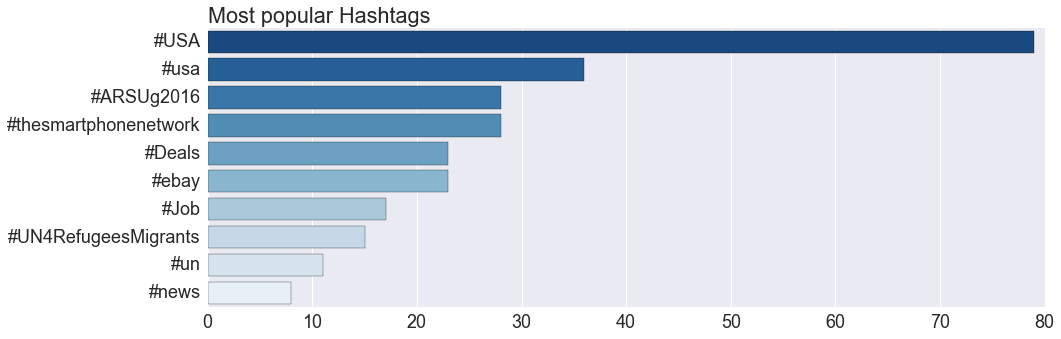

In [50]:
plotHashtags(10)